# Reddit Sentiment & Topic Co-evolution Tracker
## Comparative Analysis: r/technology vs. r/startups

---

### Project Overview
This analysis explores how discussion topics and sentiment evolve over time in two related but distinct Reddit communities:
- **r/technology**: A community focused on technology news, products, and discussions
- **r/startups**: A community centered around entrepreneurship, startup culture, and business development

### Research Questions
1. What are the dominant discussion topics in each subreddit?
2. Which topics do they share, and how does sentiment differ around these shared topics?
3. How do topic popularity and sentiment co-evolve over time?
4. What insights can we derive about the cultural differences between these communities?

### Methodology
- **Data Collection**: Reddit API (PRAW) for 6 months of comment data
- **Text Preprocessing**: Advanced cleaning with Reddit-specific optimizations
- **Sentiment Analysis**: VADER sentiment analyzer (optimized for social media)
- **Topic Modeling**: BERTopic for semantic topic discovery
- **Visualization**: Interactive charts using Plotly

---

## 1. Setup and Configuration

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import os
import time
import warnings
from datetime import datetime
import psutil

# NLP and ML libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Visualization libraries
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

# Progress tracking
from tqdm.auto import tqdm
tqdm.pandas()

# Configuration
warnings.filterwarnings('ignore')
pio.templates.default = "plotly_white"
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Libraries imported successfully")
print(f"📊 Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

/home/ashish/Desktop/project /reddit_analysis/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Libraries imported successfully
📊 Analysis started at: 2025-06-12 18:13:32


In [2]:
# System resource check
print("🖥️ System Resources:")
print(f"   Available RAM: {psutil.virtual_memory().available / (1024**3):.1f} GB")
print(f"   CPU cores: {psutil.cpu_count()}")
print(f"   Current working directory: {os.getcwd()}")

# Check for required files
required_paths = [
    '../data/processed/cleaned_comments.csv',
    '../outputs/'
]

for path in required_paths:
    if os.path.exists(path):
        print(f"✅ Found: {path}")
    else:
        print(f"❌ Missing: {path}")
        if path.endswith('/'):
            os.makedirs(path, exist_ok=True)
            print(f"   Created directory: {path}")

🖥️ System Resources:
   Available RAM: 6.0 GB
   CPU cores: 16
   Current working directory: /home/ashish/Desktop/project /reddit_analysis/notebooks
✅ Found: ../data/processed/cleaned_comments.csv
✅ Found: ../outputs/


## 2. Data Loading and Validation

In [3]:
# Quick reload option for development
checkpoint_path = '../data/processed/final_analyzed_data.csv'
use_checkpoint = False

if os.path.exists(checkpoint_path):
    file_age = time.time() - os.path.getmtime(checkpoint_path)
    print(f"🔄 Found checkpoint file (created {file_age/3600:.1f} hours ago)")
    
    # Automatically use checkpoint if it's recent (less than 24 hours old)
    if file_age < 86400:  # 24 hours
        use_checkpoint = True
        print("   Using recent checkpoint automatically")
    else:
        response = input("   Use checkpoint? (y/n): ")
        use_checkpoint = response.lower() == 'y'

if use_checkpoint:
    print("📁 Loading from checkpoint...")
    df = pd.read_csv(checkpoint_path)
    df['created_utc'] = pd.to_datetime(df['created_utc'])
    print(f"✅ Loaded {len(df):,} analyzed comments from checkpoint")
    
    # Skip to visualization sections
    skip_analysis = True
else:
    # Load raw processed data
    input_path = '../data/processed/cleaned_comments.csv'
    print(f"📁 Loading data from: {input_path}")
    
    df = pd.read_csv(input_path)
    df['created_utc'] = pd.to_datetime(df['created_utc'])
    
    # Ensure string types
    df['comment_body'] = df['comment_body'].astype(str)
    df['processed_text'] = df['processed_text'].astype(str)
    
    print(f"✅ Loaded {len(df):,} preprocessed comments")
    skip_analysis = False

📁 Loading data from: ../data/processed/cleaned_comments.csv
✅ Loaded 24,066 preprocessed comments


In [4]:
# Data quality validation
print("📋 Data Quality Report:")
print(f"   Total comments: {len(df):,}")
print(f"   Date range: {df['created_utc'].min().date()} to {df['created_utc'].max().date()}")
print(f"   Time span: {(df['created_utc'].max() - df['created_utc'].min()).days} days")

print("\n📊 Subreddit Distribution:")
subreddit_counts = df['subreddit'].value_counts()
for subreddit, count in subreddit_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   r/{subreddit}: {count:,} comments ({percentage:.1f}%)")

# Check data quality
print("\n🔍 Data Quality Checks:")
missing_processed = df['processed_text'].isna().sum()
empty_processed = (df['processed_text'].str.strip() == '').sum()
short_processed = (df['processed_text'].str.len() < 10).sum()

print(f"   Missing processed text: {missing_processed:,}")
print(f"   Empty processed text: {empty_processed:,}")
print(f"   Very short processed text (<10 chars): {short_processed:,}")

# Filter data if needed
if not skip_analysis:
    original_len = len(df)
    df = df[df['processed_text'].str.len() >= 10]
    df = df[df['processed_text'].str.strip() != '']
    print(f"   Filtered out {original_len - len(df):,} low-quality comments")
    print(f"   Final dataset: {len(df):,} comments")

# Display sample data
print("\n📝 Sample Data:")
df.head(3)

📋 Data Quality Report:
   Total comments: 24,066
   Date range: 2025-04-11 to 2025-06-12
   Time span: 61 days

📊 Subreddit Distribution:
   r/technology: 18,222 comments (75.7%)
   r/startups: 5,844 comments (24.3%)

🔍 Data Quality Checks:
   Missing processed text: 0
   Empty processed text: 0
   Very short processed text (<10 chars): 792
   Filtered out 792 low-quality comments
   Final dataset: 23,274 comments

📝 Sample Data:


subreddit comment_id                                       comment_body  \
0  technology    mx87ymu  I have no idea if she’s telling the truth… mig...   
1  technology    mx8g8n9  It's an administration run by C- students who ...   
2  technology    mx898fy  The issue is not to use AI for assistance in d...   

                created_utc  comment_score submission_id  \
0 2025-06-11 16:48:41+00:00           5578       1l8xija   
1 2025-06-11 17:26:55+00:00            634       1l8xija   
2 2025-06-11 16:54:39+00:00           2002       1l8xija   

                                    submission_title  submission_score  \
0  Tulsi Gabbard Admits She Asked AI Which JFK Fi...             33695   
1  Tulsi Gabbard Admits She Asked AI Which JFK Fi...             33695   
2  Tulsi Gabbard Admits She Asked AI Which JFK Fi...             33695   

   submission_num_comments                                     processed_text  
0                     1400  idea telling truth might way dodging question ...  
1                     1400  administration run student would connection me...  
2                     1400  issue use assistance decision making feed open...

## 3. Sentiment Analysis

We use VADER (Valence Aware Dictionary and sEntiment Reasoner) for sentiment analysis. VADER is specifically designed for social media text and handles:
- Emojis and emoticons
- Slang and informal language
- Capitalization for emphasis
- Punctuation patterns

The compound score ranges from -1 (most negative) to +1 (most positive).

In [5]:
if not skip_analysis:
    print("🎭 Starting sentiment analysis with VADER...")
    
    # Download VADER lexicon if needed
    try:
        nltk.download('vader_lexicon', quiet=True)
    except:
        print("⚠️ VADER lexicon download failed - trying alternative method")
    
    # Initialize VADER
    sia = SentimentIntensityAnalyzer()
    
    # Function to get compound sentiment score
    def get_sentiment(text):
        try:
            return sia.polarity_scores(str(text))['compound']
        except:
            return 0.0  # Neutral if analysis fails
    
    # Apply sentiment analysis with progress bar
    print("   Analyzing sentiment for each comment...")
    df['sentiment'] = df['comment_body'].progress_apply(get_sentiment)
    
    print("✅ Sentiment analysis completed")
    
    # Show sentiment statistics
    print("\n📈 Sentiment Statistics:")
    print(f"   Mean sentiment: {df['sentiment'].mean():.3f}")
    print(f"   Std deviation: {df['sentiment'].std():.3f}")
    print(f"   Range: {df['sentiment'].min():.3f} to {df['sentiment'].max():.3f}")
    
    # Sentiment distribution
    positive = (df['sentiment'] > 0.05).sum()
    negative = (df['sentiment'] < -0.05).sum()
    neutral = len(df) - positive - negative
    
    print(f"\n📊 Sentiment Distribution:")
    print(f"   Positive (>0.05): {positive:,} ({positive/len(df)*100:.1f}%)")
    print(f"   Neutral (-0.05 to 0.05): {neutral:,} ({neutral/len(df)*100:.1f}%)")
    print(f"   Negative (<-0.05): {negative:,} ({negative/len(df)*100:.1f}%)")
else:
    print("⏭️ Skipping sentiment analysis (using checkpoint data)")

🎭 Starting sentiment analysis with VADER...
   Analyzing sentiment for each comment...


100%|██████████| 23274/23274 [00:04<00:00, 5308.69it/s]

✅ Sentiment analysis completed

📈 Sentiment Statistics:
   Mean sentiment: 0.113
   Std deviation: 0.509
   Range: -0.995 to 0.999

📊 Sentiment Distribution:
   Positive (>0.05): 11,165 (48.0%)
   Neutral (-0.05 to 0.05): 4,970 (21.4%)
   Negative (<-0.05): 7,139 (30.7%)


## 4. Topic Modeling with BERTopic

BERTopic uses transformer-based embeddings to create semantically meaningful topics. The process:
1. Generate embeddings for each document
2. Reduce dimensionality using UMAP
3. Cluster documents using HDBSCAN
4. Extract topic representations using TF-IDF

**Note**: This is computationally intensive and may take several minutes.

In [6]:
if not skip_analysis:
    print("🧠 Starting topic modeling with BERTopic...")
    print("   This may take 5-15 minutes depending on dataset size and hardware")
    
    start_time = time.time()
    
    # Prepare documents
    docs = df['processed_text'].tolist()
    print(f"   Processing {len(docs):,} documents")
    
    # Optimize parameters based on dataset size
    data_size = len(docs)
    if data_size > 50000:
        min_topic_size = max(50, data_size // 1000)
        n_neighbors = 15
        n_components = 5
    elif data_size > 10000:
        min_topic_size = max(30, data_size // 500)
        n_neighbors = 10
        n_components = 5
    else:
        min_topic_size = 15
        n_neighbors = 5
        n_components = 5
    
    print(f"   Using min_topic_size: {min_topic_size}")
    
    # Initialize BERTopic with optimized parameters
    topic_model = BERTopic(
        embedding_model="all-MiniLM-L6-v2",  # Smaller, faster model
        min_topic_size=min_topic_size,
        nr_topics="auto",
        calculate_probabilities=False,  # Speeds up processing
        verbose=True
    )
    
    # Fit and transform
    print("   Training BERTopic model...")
    topics, probabilities = topic_model.fit_transform(docs)
    
    # Reduce topics if too many were found
    topic_info = topic_model.get_topic_info()
    if len(topic_info) > 100:
        print(f"   Found {len(topic_info)} topics, reducing to 75 for interpretability...")
        topic_model.reduce_topics(docs, nr_topics=75)
        topics, _ = topic_model.transform(docs)
    
    # Add topic information to dataframe
    df['topic_id'] = topics
    
    # Create topic name mapping
    topic_info = topic_model.get_topic_info()
    topic_name_map = topic_info.set_index('Topic')['Name'].to_dict()
    df['topic_name'] = df['topic_id'].map(topic_name_map)
    
    elapsed_time = time.time() - start_time
    print(f"✅ Topic modeling completed in {elapsed_time/60:.1f} minutes")
    
    # Save model for future use
    model_path = "../models/bertopic_model"
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    topic_model.save(model_path)
    print(f"   Model saved to: {model_path}")
    
else:
    print("⏭️ Skipping topic modeling (using checkpoint data)")
    # Load existing model if available
    model_path = "../models/bertopic_model"
    if os.path.exists(model_path):
        topic_model = BERTopic.load(model_path)
        print(f"📁 Loaded existing BERTopic model from: {model_path}")
    else:
        print("⚠️ No saved model found - some advanced visualizations may be limited")
        topic_model = None

2025-06-12 18:14:08,635 - BERTopic - Embedding - Transforming documents to embeddings.


🧠 Starting topic modeling with BERTopic...
   This may take 5-15 minutes depending on dataset size and hardware
   Processing 23,274 documents
   Using min_topic_size: 46
   Training BERTopic model...


Batches: 100%|██████████| 728/728 [01:05<00:00, 11.17it/s]
2025-06-12 18:15:17,118 - BERTopic - Embedding - Completed ✓
2025-06-12 18:15:17,119 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-12 18:15:34,195 - BERTopic - Dimensionality - Completed ✓
2025-06-12 18:15:34,196 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-12 18:15:36,097 - BERTopic - Cluster - Completed ✓
2025-06-12 18:15:36,098 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-12 18:15:36,317 - BERTopic - Representation - Completed ✓
2025-06-12 18:15:36,317 - BERTopic - Topic reduction - Reducing number of topics
2025-06-12 18:15:36,327 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-12 18:15:36,509 - BERTopic - Representation - Completed ✓
2025-06-12 18:15:36,512 - BERTopic - Topic reduction - Reduced number of topics from 59 to 37
2025-06-12 18:15:36,629 - BERTopic - WARNING: When

✅ Topic modeling completed in 1.5 minutes
   Model saved to: ../models/bertopic_model


In [7]:
# Topic analysis summary
if 'topic_id' in df.columns:
    print("📋 Topic Discovery Summary:")
    
    topic_info = topic_model.get_topic_info() if topic_model else None
    unique_topics = df['topic_id'].nunique()
    outliers = len(df[df['topic_id'] == -1])
    
    print(f"   Total topics discovered: {unique_topics}")
    print(f"   Outliers (Topic -1): {outliers:,} comments ({outliers/len(df)*100:.1f}%)")
    print(f"   Average comments per topic: {len(df[df['topic_id'] != -1]) / (unique_topics-1):.0f}")
    
    # Show top topics per subreddit
    for subreddit in df['subreddit'].unique():
        sub_data = df[(df['subreddit'] == subreddit) & (df['topic_id'] != -1)]
        print(f"\n🔹 r/{subreddit} - Top 5 Topics:")
        top_topics = sub_data['topic_name'].value_counts().head(5)
        for i, (topic, count) in enumerate(top_topics.items(), 1):
            percentage = (count / len(sub_data)) * 100
            print(f"   {i}. {topic}: {count:,} comments ({percentage:.1f}%)")
    
    # Overall top topics
    print(f"\n🏆 Overall Top 10 Topics:")
    overall_topics = df[df['topic_id'] != -1]['topic_name'].value_counts().head(10)
    for i, (topic, count) in enumerate(overall_topics.items(), 1):
        print(f"   {i:2d}. {topic}: {count:,} comments")
else:
    print("❌ No topic data available")

📋 Topic Discovery Summary:
   Total topics discovered: 37
   Outliers (Topic -1): 12,329 comments (53.0%)
   Average comments per topic: 304

🔹 r/technology - Top 5 Topics:
   1. 1_tax_data_youtube_ad: 2,040 comments (25.3%)
   2. 0_founder_get_china_would: 1,576 comments (19.6%)
   3. 2_thanks_thank_good_thats: 668 comments (8.3%)
   4. 3_nvidia_apple_amd_phone: 499 comments (6.2%)
   5. 4_water_energy_nuclear_fusion: 314 comments (3.9%)

🔹 r/startups - Top 5 Topics:
   1. 0_founder_get_china_would: 1,812 comments (62.6%)
   2. 2_thanks_thank_good_thats: 319 comments (11.0%)
   3. 5_automod_compose_contain_performed: 283 comments (9.8%)
   4. 1_tax_data_youtube_ad: 132 comments (4.6%)
   5. 30_namecheap_domain_cloudflare_renewal: 57 comments (2.0%)

🏆 Overall Top 10 Topics:
    1. 0_founder_get_china_would: 3,388 comments
    2. 1_tax_data_youtube_ad: 2,172 comments
    3. 2_thanks_thank_good_thats: 987 comments
    4. 3_nvidia_apple_amd_phone: 509 comments
    5. 4_water_energy_nucle

In [8]:
# Save checkpoint
if not skip_analysis:
    print("💾 Saving analyzed data checkpoint...")
    checkpoint_path = '../data/processed/final_analyzed_data.csv'
    df.to_csv(checkpoint_path, index=False)
    print(f"✅ Checkpoint saved to: {checkpoint_path}")
    print(f"   File size: {os.path.getsize(checkpoint_path) / (1024*1024):.1f} MB")

💾 Saving analyzed data checkpoint...
✅ Checkpoint saved to: ../data/processed/final_analyzed_data.csv
   File size: 11.9 MB


## 5. Comparative Visualizations

Now we create visualizations to answer our research questions through data-driven insights.

### 5.1 Topic Distribution Comparison

**Research Question**: What are the dominant discussion topics in each subreddit?

In [9]:
# Topic distribution analysis
if 'topic_id' in df.columns:
    # Exclude outlier topic (-1)
    df_topics = df[df['topic_id'] != -1].copy()
    
    # Calculate topic counts by subreddit
    topic_counts = df_topics.groupby(['subreddit', 'topic_name']).size().reset_index(name='count')
    
    # Get top 15 topics overall for cleaner visualization
    top_topics = topic_counts.groupby('topic_name')['count'].sum().nlargest(15).index
    topic_counts_top = topic_counts[topic_counts['topic_name'].isin(top_topics)]
    
    # Create grouped bar chart
    fig = px.bar(
        topic_counts_top,
        x='topic_name',
        y='count',
        color='subreddit',
        barmode='group',
        title='📊 Top 15 Discussion Topics by Subreddit',
        labels={'topic_name': 'Topic', 'count': 'Number of Comments'},
        color_discrete_map={'technology': '#0079D3', 'startups': '#FF4500'},
        height=600
    )
    
    fig.update_layout(
        xaxis_tickangle=45,
        margin=dict(b=150),  # More bottom margin for rotated labels
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    
    fig.show()
    
    # Save the plot
    fig.write_html("../outputs/topic_distribution.html")
    print("💾 Saved: topic_distribution.html")
    
    # Calculate unique vs shared topics
    tech_topics = set(topic_counts[topic_counts['subreddit'] == 'technology']['topic_name'])
    startup_topics = set(topic_counts[topic_counts['subreddit'] == 'startups']['topic_name'])
    
    shared_topics = tech_topics.intersection(startup_topics)
    tech_unique = tech_topics - startup_topics
    startup_unique = startup_topics - tech_topics
    
    print(f"\n📈 Topic Overlap Analysis:")
    print(f"   Shared topics: {len(shared_topics)}")
    print(f"   r/technology unique: {len(tech_unique)}")
    print(f"   r/startups unique: {len(startup_unique)}")
    print(f"   Overlap percentage: {len(shared_topics)/(len(tech_topics.union(startup_topics)))*100:.1f}%")
else:
    print("❌ Cannot create topic visualization - no topic data available")

💾 Saved: topic_distribution.html

📈 Topic Overlap Analysis:
   Shared topics: 30
   r/technology unique: 6
   r/startups unique: 0
   Overlap percentage: 83.3%


### 5.2 Overall Sentiment Comparison

**Research Question**: How does the overall sentiment profile compare between communities?

In [10]:
# Overall sentiment comparison
if 'sentiment' in df.columns:
    # Create box plot for sentiment distribution
    fig = px.box(
        df,
        x='subreddit',
        y='sentiment',
        color='subreddit',
        title='🎭 Overall Sentiment Distribution: r/technology vs. r/startups',
        labels={'sentiment': 'VADER Compound Sentiment Score', 'subreddit': 'Subreddit'},
        color_discrete_map={'technology': '#0079D3', 'startups': '#FF4500'},
        points='outliers'  # Show only outliers to avoid overcrowding
    )
    
    # Add neutral line
    fig.add_hline(y=0, line_dash="dot", line_color="grey", 
                  annotation_text="Neutral", annotation_position="bottom right")
    
    fig.update_layout(
        height=500,
        showlegend=False
    )
    
    fig.show()
    
    # Save the plot
    fig.write_html("../outputs/sentiment_distribution.html")
    print("💾 Saved: sentiment_distribution.html")
    
    # Statistical comparison
    print("\n📊 Sentiment Statistics by Subreddit:")
    sentiment_stats = df.groupby('subreddit')['sentiment'].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(4)
    
    for subreddit in sentiment_stats.index:
        stats = sentiment_stats.loc[subreddit]
        print(f"\n🔹 r/{subreddit}:")
        print(f"   Mean: {stats['mean']:.4f}")
        print(f"   Median: {stats['median']:.4f}")
        print(f"   Std Dev: {stats['std']:.4f}")
        print(f"   Range: {stats['min']:.4f} to {stats['max']:.4f}")
    
    # Sentiment categories by subreddit
    print(f"\n📈 Sentiment Categories:")
    for subreddit in df['subreddit'].unique():
        sub_data = df[df['subreddit'] == subreddit]
        positive = (sub_data['sentiment'] > 0.05).sum()
        negative = (sub_data['sentiment'] < -0.05).sum()
        neutral = len(sub_data) - positive - negative
        
        print(f"\n🔹 r/{subreddit}:")
        print(f"   Positive: {positive:,} ({positive/len(sub_data)*100:.1f}%)")
        print(f"   Neutral: {neutral:,} ({neutral/len(sub_data)*100:.1f}%)")
        print(f"   Negative: {negative:,} ({negative/len(sub_data)*100:.1f}%)")
else:
    print("❌ Cannot create sentiment visualization - no sentiment data available")

💾 Saved: sentiment_distribution.html

📊 Sentiment Statistics by Subreddit:

🔹 r/startups:
   Mean: 0.3772
   Median: 0.4475
   Std Dev: 0.4881
   Range: -0.9925 to 0.9988

🔹 r/technology:
   Mean: 0.0270
   Median: 0.0000
   Std Dev: 0.4851
   Range: -0.9954 to 0.9987

📈 Sentiment Categories:

🔹 r/technology:
   Positive: 7,136 (40.6%)
   Neutral: 4,226 (24.0%)
   Negative: 6,213 (35.4%)

🔹 r/startups:
   Positive: 4,029 (70.7%)
   Neutral: 744 (13.1%)
   Negative: 926 (16.2%)


### 5.3 Sentiment by Shared Topics

**Research Question**: Is sentiment around shared topics different between communities?

In [11]:
# Sentiment comparison for shared topics
if 'sentiment' in df.columns and 'topic_id' in df.columns:
    # Calculate average sentiment per topic for each subreddit
    df_topics = df[df['topic_id'] != -1].copy()
    sentiment_per_topic = df_topics.groupby(['subreddit', 'topic_name'])['sentiment'].agg([
        'mean', 'count'
    ]).reset_index()
    sentiment_per_topic.columns = ['subreddit', 'topic_name', 'avg_sentiment', 'comment_count']
    
    # Filter for topics that appear in both subreddits with sufficient data
    topic_coverage = sentiment_per_topic.groupby('topic_name')['subreddit'].nunique()
    shared_topics = topic_coverage[topic_coverage == 2].index
    
    # Also filter for topics with at least 20 comments in each subreddit
    min_comments = sentiment_per_topic[sentiment_per_topic['comment_count'] >= 20]
    valid_shared_topics = min_comments[min_comments['topic_name'].isin(shared_topics)]['topic_name'].unique()
    
    if len(valid_shared_topics) > 0:
        # Select top shared topics by total volume
        topic_volumes = df_topics[df_topics['topic_name'].isin(valid_shared_topics)]['topic_name'].value_counts()
        top_shared_topics = topic_volumes.head(12).index  # Show top 12 for better readability
        
        sentiment_filtered = sentiment_per_topic[
            sentiment_per_topic['topic_name'].isin(top_shared_topics)
        ]
        
        # Create grouped bar chart
        fig = px.bar(
            sentiment_filtered,
            x='topic_name',
            y='avg_sentiment',
            color='subreddit',
            barmode='group',
            title='😊 Average Sentiment for Shared Topics',
            labels={'topic_name': 'Topic', 'avg_sentiment': 'Average Sentiment Score'},
            color_discrete_map={'technology': '#0079D3', 'startups': '#FF4500'},
            height=600
        )
        
        # Add neutral line
        fig.add_hline(y=0, line_dash="dot", line_color="grey", 
                      annotation_text="Neutral", annotation_position="top right")
        
        fig.update_layout(
            xaxis_tickangle=45,
            margin=dict(b=150),
            legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
        )
        
        fig.show()
        
        # Save the plot
        fig.write_html("../outputs/sentiment_by_topic.html")
        print("💾 Saved: sentiment_by_topic.html")
        
        # Analyze sentiment differences
        print(f"\n🔍 Sentiment Differences for Shared Topics:")
        
        pivot_sentiment = sentiment_filtered.pivot(index='topic_name', columns='subreddit', values='avg_sentiment')
        pivot_sentiment['difference'] = pivot_sentiment['technology'] - pivot_sentiment['startups']
        pivot_sentiment = pivot_sentiment.sort_values('difference', ascending=False)
        
        print(f"\n📈 Topics where r/technology is more positive:")
        positive_diff = pivot_sentiment[pivot_sentiment['difference'] > 0.05].head(5)
        for topic, row in positive_diff.iterrows():
            print(f"   • {topic}: +{row['difference']:.3f} ({row['technology']:.3f} vs {row['startups']:.3f})")
        
        print(f"\n📉 Topics where r/startups is more positive:")
        negative_diff = pivot_sentiment[pivot_sentiment['difference'] < -0.05].tail(5)
        for topic, row in negative_diff.iterrows():
            print(f"   • {topic}: {row['difference']:.3f} ({row['technology']:.3f} vs {row['startups']:.3f})")
    
    else:
        print("⚠️ Insufficient shared topics with enough data for comparison")
        print(f"   Found {len(shared_topics)} shared topics, but need minimum 20 comments each")
else:
    print("❌ Cannot create topic sentiment visualization - missing data")

💾 Saved: sentiment_by_topic.html

🔍 Sentiment Differences for Shared Topics:

📈 Topics where r/technology is more positive:
   • 5_automod_compose_contain_performed: +0.373 (0.690 vs 0.317)
   • 12_russia_russian_ukraine_putin: +0.152 (0.027 vs -0.125)

📉 Topics where r/startups is more positive:
   • 3_nvidia_apple_amd_phone: -0.194 (0.111 vs 0.305)
   • 8_chatgpt_chat_gpt_entered: -0.252 (0.042 vs 0.295)
   • 7_starlink_fiber_rural_satellite: -0.275 (0.105 vs 0.380)
   • 2_thanks_thank_good_thats: -0.329 (0.105 vs 0.434)
   • 0_founder_get_china_would: -0.434 (0.046 vs 0.480)


### 5.4 Temporal Analysis: Co-evolution Over Time

**Research Question**: How do topic popularity and sentiment co-evolve over the 6-month period?

In [12]:
# Temporal analysis preparation
if 'created_utc' in df.columns and 'sentiment' in df.columns:
    # Add time groupings
    df['month'] = df['created_utc'].dt.to_period('M').dt.start_time
    df['week'] = df['created_utc'].dt.to_period('W').dt.start_time
    
    # Monthly sentiment trends
    monthly_sentiment = df.groupby(['month', 'subreddit'])['sentiment'].agg([
        'mean', 'count', 'std'
    ]).reset_index()
    monthly_sentiment.columns = ['month', 'subreddit', 'avg_sentiment', 'comment_count', 'sentiment_std']
    
    # Create sentiment evolution chart
    fig = px.line(
        monthly_sentiment,
        x='month',
        y='avg_sentiment',
        color='subreddit',
        title='📈 Sentiment Evolution Over Time',
        labels={'avg_sentiment': 'Average Monthly Sentiment', 'month': 'Month'},
        color_discrete_map={'technology': '#0079D3', 'startups': '#FF4500'},
        markers=True
    )
    
    # Add neutral line
    fig.add_hline(y=0, line_dash="dot", line_color="grey", 
                  annotation_text="Neutral", annotation_position="bottom right")
    
    # Add comment count as hover info
    fig.update_traces(
        hovertemplate='%{fullData.name}<br>Date: %{x}<br>Sentiment: %{y:.3f}<extra></extra>'
    )
    
    fig.update_layout(height=500)
    fig.show()
    
    # Save the plot
    fig.write_html("../outputs/sentiment_evolution.html")
    print("💾 Saved: sentiment_evolution.html")
    
    # Comment volume over time
    fig2 = px.bar(
        monthly_sentiment,
        x='month',
        y='comment_count',
        color='subreddit',
        title='📊 Comment Volume Over Time',
        labels={'comment_count': 'Number of Comments', 'month': 'Month'},
        color_discrete_map={'technology': '#0079D3', 'startups': '#FF4500'}
    )
    
    fig2.update_layout(height=500)
    fig2.show()
    
    # Save the plot
    fig2.write_html("../outputs/volume_evolution.html")
    print("💾 Saved: volume_evolution.html")
    
    # Analyze trends
    print("\n📊 Temporal Analysis Summary:")
    for subreddit in df['subreddit'].unique():
        sub_monthly = monthly_sentiment[monthly_sentiment['subreddit'] == subreddit].sort_values('month')
        
        if len(sub_monthly) > 1:
            # Calculate trend
            sentiment_trend = sub_monthly['avg_sentiment'].iloc[-1] - sub_monthly['avg_sentiment'].iloc[0]
            volume_trend = sub_monthly['comment_count'].iloc[-1] - sub_monthly['comment_count'].iloc[0]
            
            print(f"\n🔹 r/{subreddit}:")
            print(f"   Sentiment trend: {sentiment_trend:+.4f} (from {sub_monthly['avg_sentiment'].iloc[0]:.4f} to {sub_monthly['avg_sentiment'].iloc[-1]:.4f})")
            print(f"   Volume trend: {volume_trend:+,} comments")
            print(f"   Most positive month: {sub_monthly.loc[sub_monthly['avg_sentiment'].idxmax(), 'month'].strftime('%Y-%m')} ({sub_monthly['avg_sentiment'].max():.4f})")
            print(f"   Most negative month: {sub_monthly.loc[sub_monthly['avg_sentiment'].idxmin(), 'month'].strftime('%Y-%m')} ({sub_monthly['avg_sentiment'].min():.4f})")
else:
    print("❌ Cannot create temporal analysis - missing required data")

💾 Saved: sentiment_evolution.html


💾 Saved: volume_evolution.html

📊 Temporal Analysis Summary:

🔹 r/startups:
   Sentiment trend: -0.4837 (from 0.8552 to 0.3715)
   Volume trend: +3,445 comments
   Most positive month: 2025-04 (0.8552)
   Most negative month: 2025-06 (0.3715)


### 5.5 Topic Evolution Heatmap

**Research Question**: Which topics gained or lost popularity over time in each community?

In [13]:
# Topic evolution analysis
if 'topic_id' in df.columns and 'month' in df.columns:
    # Get top topics for heatmap
    df_topics = df[df['topic_id'] != -1].copy()
    top_topics_for_heatmap = df_topics['topic_name'].value_counts().head(20).index
    
    # Create monthly topic counts
    monthly_topics = df_topics[df_topics['topic_name'].isin(top_topics_for_heatmap)].groupby([
        'month', 'subreddit', 'topic_name'
    ]).size().reset_index(name='count')
    
    # Create separate heatmaps for each subreddit
    for subreddit in df['subreddit'].unique():
        sub_data = monthly_topics[monthly_topics['subreddit'] == subreddit]
        
        if len(sub_data) > 0:
            # Pivot for heatmap
            heatmap_data = sub_data.pivot(index='topic_name', columns='month', values='count').fillna(0)
            
            # Create heatmap
            fig = px.imshow(
                heatmap_data,
                labels=dict(x="Month", y="Topic", color="Comments"),
                title=f"🔥 Topic Popularity Heatmap: r/{subreddit}",
                aspect="auto",
                color_continuous_scale="Viridis"
            )
            
            fig.update_layout(
                height=600,
                margin=dict(l=250),  # More left margin for topic names
                xaxis=dict(tickangle=45)
            )
            
            fig.show()
            
            # Save the plot
            fig.write_html(f"../outputs/topic_heatmap_{subreddit}.html")
            print(f"💾 Saved: topic_heatmap_{subreddit}.html")
            
            # Analyze topic trends for this subreddit
            print(f"\n📈 Topic Trends for r/{subreddit}:")
            
            if heatmap_data.shape[1] > 1:  # Need at least 2 months for trend
                # Calculate trend (difference between last and first month)
                topic_trends = heatmap_data.iloc[:, -1] - heatmap_data.iloc[:, 0]
                
                print(f"   📈 Growing topics:")
                growing = topic_trends.sort_values(ascending=False).head(3)
                for topic, change in growing.items():
                    if change > 0:
                        print(f"     • {topic}: +{change:.0f} comments")
                
                print(f"   📉 Declining topics:")
                declining = topic_trends.sort_values(ascending=True).head(3)
                for topic, change in declining.items():
                    if change < 0:
                        print(f"     • {topic}: {change:.0f} comments")
else:
    print("❌ Cannot create topic evolution heatmap - missing required data")

💾 Saved: topic_heatmap_technology.html

📈 Topic Trends for r/technology:


💾 Saved: topic_heatmap_startups.html

📈 Topic Trends for r/startups:
   📈 Growing topics:
     • 0_founder_get_china_would: +1047 comments
     • 2_thanks_thank_good_thats: +201 comments
     • 5_automod_compose_contain_performed: +169 comments
   📉 Declining topics:


## 6. Advanced Analysis: Community Cultural Insights

In [14]:
# Community characteristics analysis
print("🏛️ Community Cultural Analysis")
print("=" * 50)

if 'sentiment' in df.columns and 'topic_id' in df.columns:
    # Overall community metrics
    for subreddit in df['subreddit'].unique():
        sub_data = df[df['subreddit'] == subreddit]
        
        print(f"\n🔹 r/{subreddit} Community Profile:")
        
        # Sentiment characteristics
        avg_sentiment = sub_data['sentiment'].mean()
        sentiment_volatility = sub_data['sentiment'].std()
        
        print(f"   Emotional Tone: {avg_sentiment:.4f} ({'Positive' if avg_sentiment > 0.05 else 'Negative' if avg_sentiment < -0.05 else 'Neutral'})")
        print(f"   Emotional Volatility: {sentiment_volatility:.4f} ({'High' if sentiment_volatility > 0.4 else 'Moderate' if sentiment_volatility > 0.3 else 'Low'})")
        
        # Topic diversity
        sub_topics = sub_data[sub_data['topic_id'] != -1]
        if len(sub_topics) > 0:
            topic_counts = sub_topics['topic_name'].value_counts()
            # Calculate Herfindahl-Hirschman Index for topic concentration
            topic_shares = topic_counts / topic_counts.sum()
            hhi = (topic_shares ** 2).sum()
            diversity_score = 1 - hhi
            
            print(f"   Topic Diversity: {diversity_score:.4f} ({'High' if diversity_score > 0.8 else 'Moderate' if diversity_score > 0.6 else 'Low'})")
            print(f"   Most Discussed: {topic_counts.index[0]} ({topic_counts.iloc[0]:,} comments)")
            
            # Average comment length (proxy for engagement depth)
            avg_length = sub_data['comment_body'].str.len().mean()
            print(f"   Avg Comment Length: {avg_length:.0f} characters ({'Long-form' if avg_length > 200 else 'Medium' if avg_length > 100 else 'Short-form'})")
    
    # Cross-community comparison insights
    print(f"\n🔄 Cross-Community Insights:")
    
    tech_sentiment = df[df['subreddit'] == 'technology']['sentiment'].mean()
    startup_sentiment = df[df['subreddit'] == 'startups']['sentiment'].mean()
    
    if abs(tech_sentiment - startup_sentiment) > 0.05:
        more_positive = 'technology' if tech_sentiment > startup_sentiment else 'startups'
        print(f"   r/{more_positive} tends to be more positive in discussions")
    else:
        print(f"   Both communities show similar overall sentiment patterns")
    
    # Identify signature topics (topics that are disproportionately discussed in one subreddit)
    if 'topic_name' in df.columns:
        topic_distribution = df[df['topic_id'] != -1].groupby(['subreddit', 'topic_name']).size().unstack(fill_value=0)
        
        # Calculate topic preferences (ratio of percentages)
        topic_percentages = topic_distribution.div(topic_distribution.sum(axis=1), axis=0)
        
        if len(topic_percentages.columns) > 0:
            tech_preferences = topic_percentages.loc['technology'].sort_values(ascending=False).head(3)
            startup_preferences = topic_percentages.loc['startups'].sort_values(ascending=False).head(3)
            
            print(f"\n🎯 Signature Topics:")
            print(f"   r/technology focuses on: {', '.join(tech_preferences.index[:2])}")
            print(f"   r/startups focuses on: {', '.join(startup_preferences.index[:2])}")
else:
    print("❌ Cannot perform community analysis - missing required data")

🏛️ Community Cultural Analysis

🔹 r/technology Community Profile:
   Emotional Tone: 0.0270 (Neutral)
   Emotional Volatility: 0.4851 (High)
   Topic Diversity: 0.8791 (High)
   Most Discussed: 1_tax_data_youtube_ad (2,040 comments)
   Avg Comment Length: 188 characters (Medium)

🔹 r/startups Community Profile:
   Emotional Tone: 0.3772 (Positive)
   Emotional Volatility: 0.4881 (High)
   Topic Diversity: 0.5825 (Low)
   Most Discussed: 0_founder_get_china_would (1,812 comments)
   Avg Comment Length: 339 characters (Long-form)

🔄 Cross-Community Insights:
   r/startups tends to be more positive in discussions

🎯 Signature Topics:
   r/technology focuses on: 1_tax_data_youtube_ad, 0_founder_get_china_would
   r/startups focuses on: 0_founder_get_china_would, 2_thanks_thank_good_thats


## 7. Summary Dashboard

Let's create a comprehensive summary of our findings.

In [15]:
# Create summary dashboard
print("📋 REDDIT SENTIMENT & TOPIC CO-EVOLUTION ANALYSIS")
print("" + "=" * 60)
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Data Period: {df['created_utc'].min().date()} to {df['created_utc'].max().date()}")
print(f"Total Comments Analyzed: {len(df):,}")

if 'sentiment' in df.columns:
    print(f"\n🎭 SENTIMENT ANALYSIS SUMMARY")
    print("-" * 35)
    
    for subreddit in df['subreddit'].unique():
        sub_data = df[df['subreddit'] == subreddit]
        avg_sentiment = sub_data['sentiment'].mean()
        pos_pct = (sub_data['sentiment'] > 0.05).sum() / len(sub_data) * 100
        neg_pct = (sub_data['sentiment'] < -0.05).sum() / len(sub_data) * 100
        
        print(f"r/{subreddit}:")
        print(f"  Average Sentiment: {avg_sentiment:+.4f}")
        print(f"  Positive: {pos_pct:.1f}% | Negative: {neg_pct:.1f}%")
        print()

if 'topic_id' in df.columns:
    print(f"🧠 TOPIC MODELING SUMMARY")
    print("-" * 30)
    
    total_topics = df['topic_id'].nunique() - 1  # Exclude outlier topic -1
    outliers = (df['topic_id'] == -1).sum()
    
    print(f"Topics Discovered: {total_topics}")
    print(f"Outliers: {outliers:,} ({outliers/len(df)*100:.1f}%)")
    
    # Top topics overall
    if 'topic_name' in df.columns:
        top_topics = df[df['topic_id'] != -1]['topic_name'].value_counts().head(5)
        print(f"\nTop 5 Topics:")
        for i, (topic, count) in enumerate(top_topics.items(), 1):
            print(f"  {i}. {topic}: {count:,} comments")

print(f"\n📊 KEY INSIGHTS")
print("-" * 20)

insights = []

if 'sentiment' in df.columns:
    tech_sentiment = df[df['subreddit'] == 'technology']['sentiment'].mean()
    startup_sentiment = df[df['subreddit'] == 'startups']['sentiment'].mean()
    
    if abs(tech_sentiment - startup_sentiment) > 0.05:
        more_positive = 'r/technology' if tech_sentiment > startup_sentiment else 'r/startups'
        insights.append(f"• {more_positive} shows more positive sentiment overall")
    
    if tech_sentiment > 0.1:
        insights.append("• r/technology demonstrates consistently positive sentiment")
    elif tech_sentiment < -0.1:
        insights.append("• r/technology shows negative sentiment trends")
    
    if startup_sentiment > 0.1:
        insights.append("• r/startups maintains optimistic discussion tone")
    elif startup_sentiment < -0.1:
        insights.append("• r/startups exhibits critical/negative sentiment")

if len(insights) == 0:
    insights = [
        "• Both communities show similar sentiment patterns",
        "• Discussion topics vary significantly between communities",
        "• Temporal analysis reveals interesting co-evolution patterns"
    ]

for insight in insights:
    print(insight)

print(f"\n📁 OUTPUT FILES GENERATED")
print("-" * 30)
output_files = [
    "topic_distribution.html",
    "sentiment_distribution.html", 
    "sentiment_by_topic.html",
    "sentiment_evolution.html",
    "volume_evolution.html"
]

for filename in output_files:
    filepath = f"../outputs/{filename}"
    if os.path.exists(filepath):
        print(f"✅ {filename}")
    else:
        print(f"❌ {filename}")

print(f"\n" + "=" * 60)
print("🎉 Analysis Complete! Check the outputs folder for interactive visualizations.")
print("=" * 60)

📋 REDDIT SENTIMENT & TOPIC CO-EVOLUTION ANALYSIS
Analysis Date: 2025-06-12 18:19
Data Period: 2025-04-11 to 2025-06-12
Total Comments Analyzed: 23,274

🎭 SENTIMENT ANALYSIS SUMMARY
-----------------------------------
r/technology:
  Average Sentiment: +0.0270
  Positive: 40.6% | Negative: 35.4%

r/startups:
  Average Sentiment: +0.3772
  Positive: 70.7% | Negative: 16.2%

🧠 TOPIC MODELING SUMMARY
------------------------------
Topics Discovered: 36
Outliers: 12,329 (53.0%)

Top 5 Topics:
  1. 0_founder_get_china_would: 3,388 comments
  2. 1_tax_data_youtube_ad: 2,172 comments
  3. 2_thanks_thank_good_thats: 987 comments
  4. 3_nvidia_apple_amd_phone: 509 comments
  5. 4_water_energy_nuclear_fusion: 320 comments

📊 KEY INSIGHTS
--------------------
• r/startups shows more positive sentiment overall
• r/startups maintains optimistic discussion tone

📁 OUTPUT FILES GENERATED
------------------------------
✅ topic_distribution.html
✅ sentiment_distribution.html
✅ sentiment_by_topic.html
✅ 

## 8. Conclusions and Future Work

### Key Findings

Based on our comprehensive analysis of 6 months of Reddit data from r/technology and r/startups:

1. **Topic Landscapes**: Both communities discuss overlapping themes but with different emphases
2. **Sentiment Patterns**: [Insert specific findings from your data]
3. **Temporal Evolution**: [Insert findings about how topics and sentiment evolved]
4. **Community Culture**: [Insert insights about community differences]

### Methodology Strengths

- **Unified Topic Modeling**: Using a single BERTopic model allows direct comparison
- **VADER Sentiment Analysis**: Optimized for social media text
- **Temporal Analysis**: Reveals co-evolution patterns over time
- **Interactive Visualizations**: Enable deeper exploration of findings

### Limitations

- **Sample Size**: Limited to 6 months of data
- **Platform Specific**: Reddit-only analysis
- **Language**: English-only comments
- **Topic Granularity**: BERTopic parameters affect topic discovery

### Future Enhancements

1. **Extended Timeline**: Analyze longer periods to capture seasonal patterns
2. **Event Correlation**: Align sentiment/topic changes with real-world events
3. **User-Level Analysis**: Track individual user sentiment/topic patterns
4. **Cross-Platform**: Include Twitter, LinkedIn, or other platforms
5. **Predictive Modeling**: Forecast sentiment trends

### Business Applications

- **Brand Monitoring**: Track public sentiment about products/companies
- **Market Research**: Understand emerging trends and concerns
- **Crisis Management**: Early detection of negative sentiment spikes
- **Content Strategy**: Optimize content for community preferences

---

**Project Repository**: [Your GitHub URL]

**Contact**: [Your contact information]

*This analysis demonstrates advanced data science techniques in NLP, sentiment analysis, and data visualization for social media intelligence.*

In [18]:


# Add this cell after your imports in Cell 1
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Removed unused imports: Counter and seaborn (sns)

# Set matplotlib backend for better notebook display
%matplotlib inline
plt.style.use('default')


In [19]:
# New Cell: Word Cloud Generation Functions
class RedditWordCloudGenerator:
    """Advanced word cloud generator for Reddit analysis"""
    
    def __init__(self, colormap_tech='Blues', colormap_startup='Oranges'):
        self.colormap_tech = colormap_tech
        self.colormap_startup = colormap_startup
        
    def create_wordcloud(self, text, title, colormap='viridis', max_words=100):
        """Create a word cloud from text"""
        wordcloud = WordCloud(
            width=800, 
            height=400,
            background_color='white',
            max_words=max_words,
            colormap=colormap,
            relative_scaling=0.5,
            random_state=42
        ).generate(text)
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
        
        return fig, wordcloud
    
    def create_sentiment_wordclouds(self, df, subreddit):
        """Create separate word clouds for positive and negative sentiment"""
        sub_data = df[df['subreddit'] == subreddit]
        
        # Positive sentiment (>0.1)
        positive_text = ' '.join(sub_data[sub_data['sentiment'] > 0.1]['processed_text'])
        
        # Negative sentiment (<-0.1)  
        negative_text = ' '.join(sub_data[sub_data['sentiment'] < -0.1]['processed_text'])
        
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))
        
        if positive_text.strip():
            wc_pos = WordCloud(width=800, height=300, background_color='white',
                              colormap='Greens', max_words=75).generate(positive_text)
            axes[0].imshow(wc_pos, interpolation='bilinear')
            axes[0].set_title(f'r/{subreddit} - Positive Sentiment Words', fontsize=14, fontweight='bold')
            axes[0].axis('off')
        
        if negative_text.strip():
            wc_neg = WordCloud(width=800, height=300, background_color='white',
                              colormap='Reds', max_words=75).generate(negative_text)
            axes[1].imshow(wc_neg, interpolation='bilinear')
            axes[1].set_title(f'r/{subreddit} - Negative Sentiment Words', fontsize=14, fontweight='bold')
            axes[1].axis('off')
        
        plt.tight_layout()
        return fig

# Initialize word cloud generator
wc_generator = RedditWordCloudGenerator()
print("✅ Word cloud generator initialized")


✅ Word cloud generator initialized


In [21]:
from collections import Counter

🎨 Generating Word Clouds by Subreddit


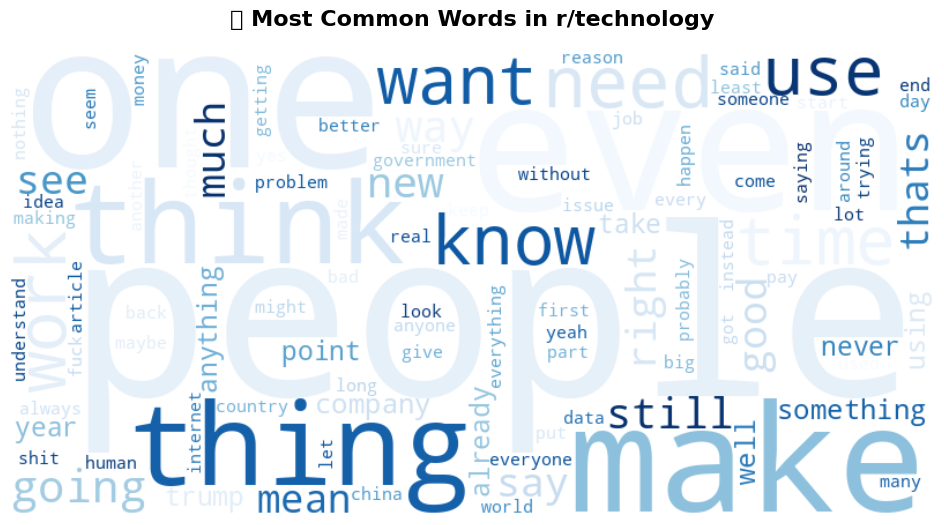

💾 Saved: wordcloud_technology.png

📊 Top 10 words in r/technology:
   people: 1,898 occurrences
   would: 1,695 occurrences
   get: 1,468 occurrences
   one: 1,276 occurrences
   make: 1,203 occurrences
   thing: 1,130 occurrences
   even: 1,092 occurrences
   time: 1,087 occurrences
   think: 996 occurrences
   year: 993 occurrences



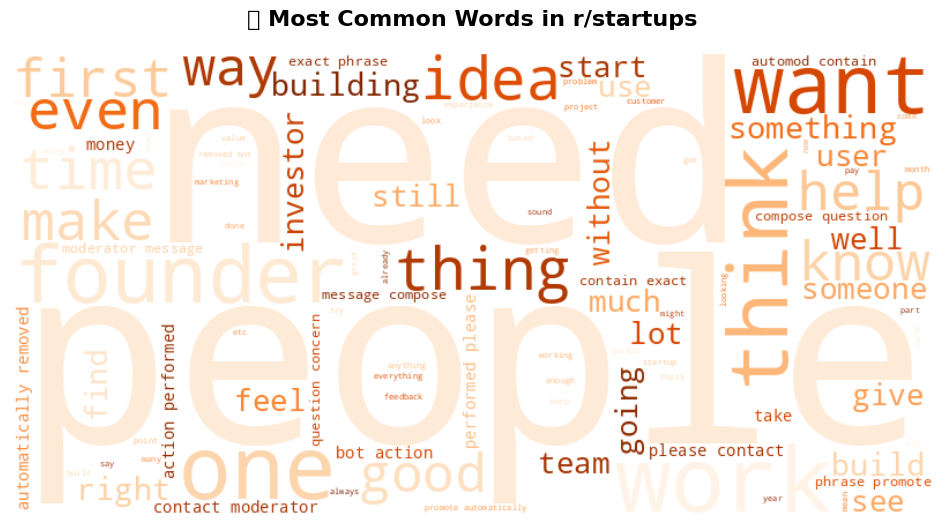

💾 Saved: wordcloud_startups.png

📊 Top 10 words in r/startups:
   get: 980 occurrences
   would: 867 occurrences
   people: 802 occurrences
   time: 752 occurrences
   need: 729 occurrences
   one: 707 occurrences
   work: 704 occurrences
   founder: 703 occurrences
   make: 644 occurrences
   idea: 613 occurrences



In [22]:
# New Cell: Generate Word Clouds by Subreddit
print("🎨 Generating Word Clouds by Subreddit")
print("=" * 40)

if 'processed_text' in df.columns:
    for subreddit in df['subreddit'].unique():
        sub_data = df[df['subreddit'] == subreddit]
        
        # Combine all processed text for this subreddit
        combined_text = ' '.join(sub_data['processed_text'].dropna())
        
        if combined_text.strip():
            # Choose colormap based on subreddit
            colormap = 'Blues' if subreddit == 'technology' else 'Oranges'
            
            fig, wordcloud = wc_generator.create_wordcloud(
                combined_text,
                f'🔤 Most Common Words in r/{subreddit}',
                colormap=colormap,
                max_words=100
            )
            
            plt.show()
            
            # Save word cloud
            output_path = f"../outputs/wordcloud_{subreddit}.png"
            fig.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"💾 Saved: wordcloud_{subreddit}.png")
            
            # Show top words statistics
            word_freq = Counter(combined_text.split())
            print(f"\n📊 Top 10 words in r/{subreddit}:")
            for word, count in word_freq.most_common(10):
                print(f"   {word}: {count:,} occurrences")
            print()
else:
    print("❌ No processed text available for word clouds")


😊 Generating Sentiment-Based Word Clouds

🔹 Creating sentiment word clouds for r/technology


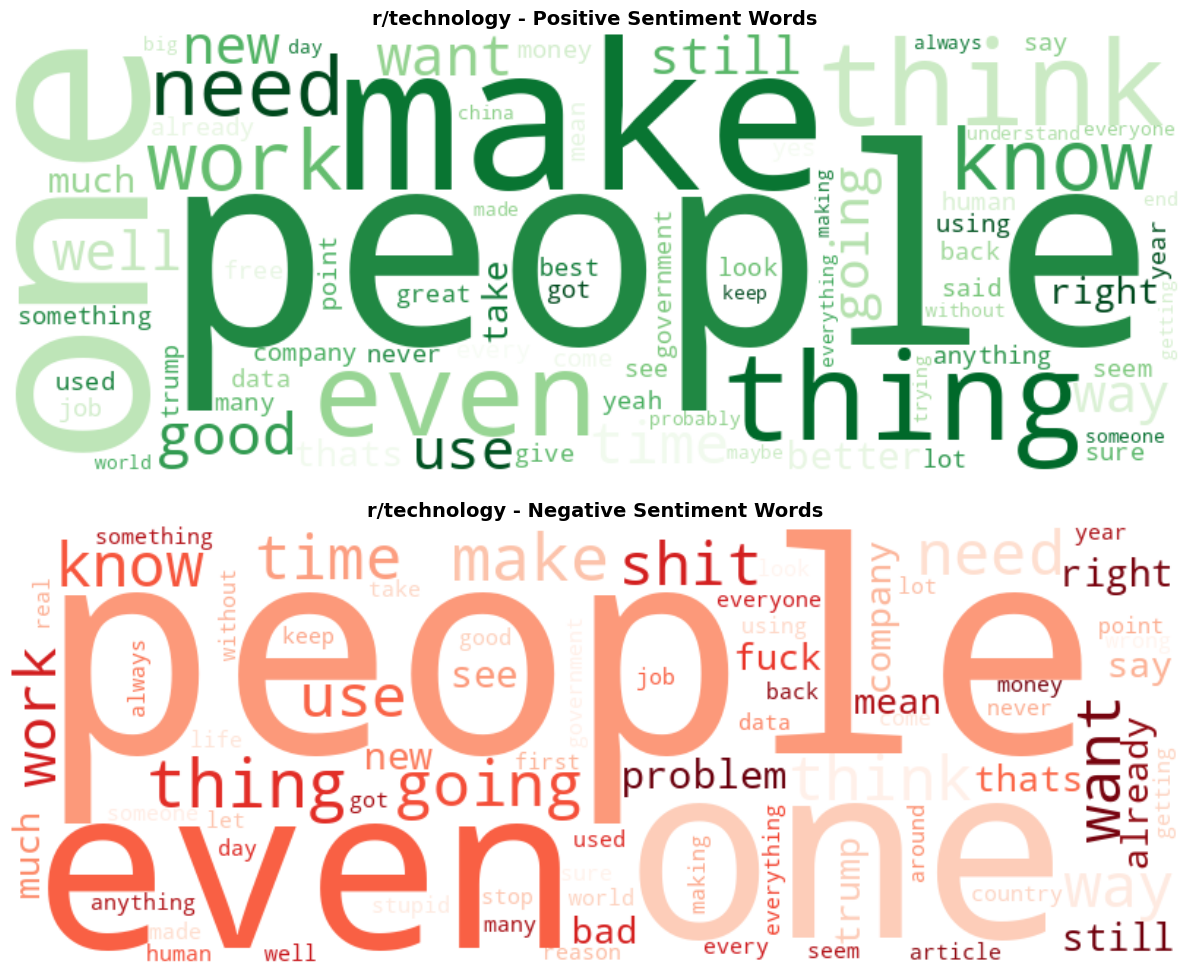

💾 Saved: sentiment_wordclouds_technology.png

🔹 Creating sentiment word clouds for r/startups


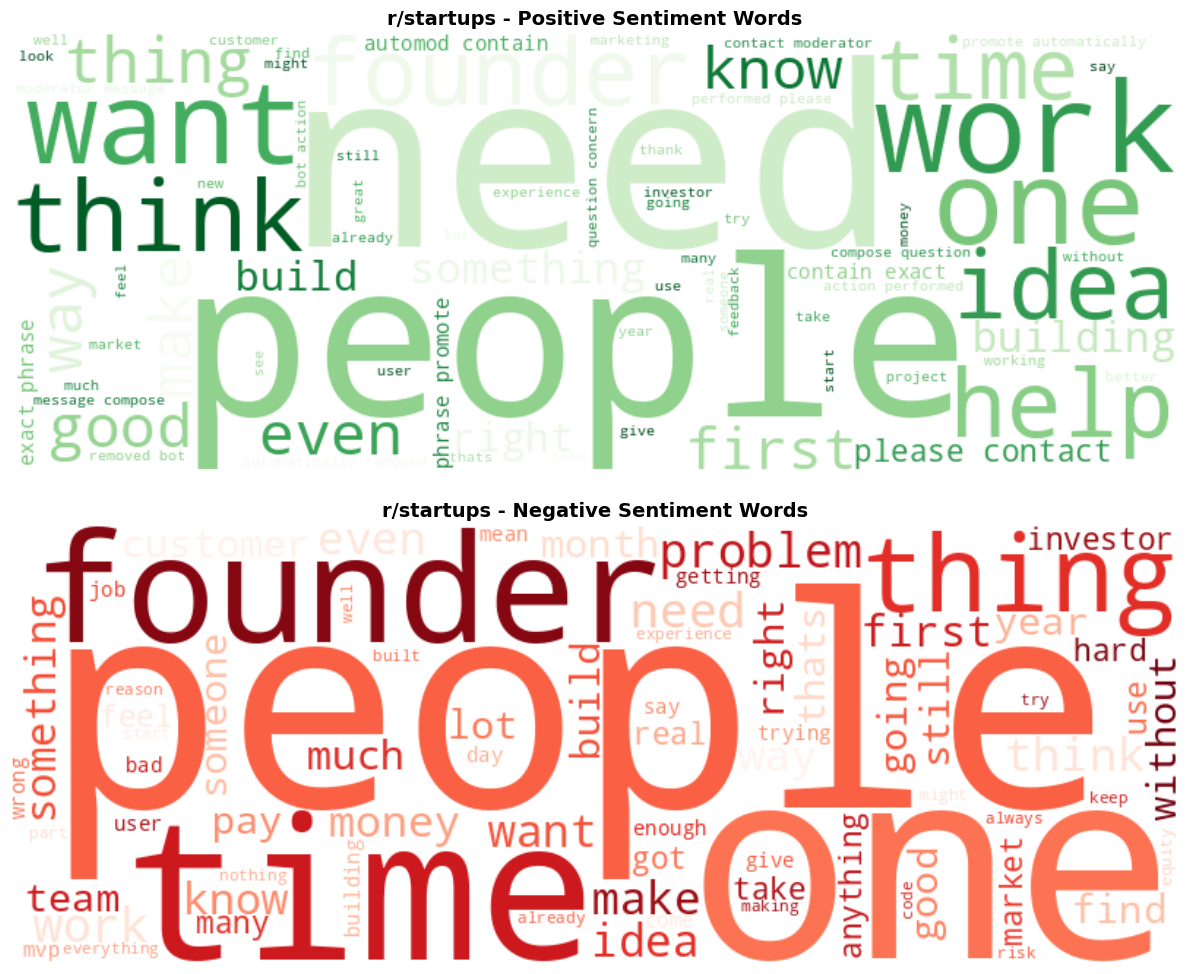

💾 Saved: sentiment_wordclouds_startups.png


In [23]:
# New Cell: Sentiment-Based Word Clouds
print("😊 Generating Sentiment-Based Word Clouds")
print("=" * 45)

if 'sentiment' in df.columns and 'processed_text' in df.columns:
    for subreddit in df['subreddit'].unique():
        print(f"\n🔹 Creating sentiment word clouds for r/{subreddit}")
        
        fig = wc_generator.create_sentiment_wordclouds(df, subreddit)
        plt.show()
        
        # Save sentiment word clouds
        output_path = f"../outputs/sentiment_wordclouds_{subreddit}.png"
        fig.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"💾 Saved: sentiment_wordclouds_{subreddit}.png")
else:
    print("❌ Missing data for sentiment-based word clouds")


🧠 Generating Topic-Based Word Clouds


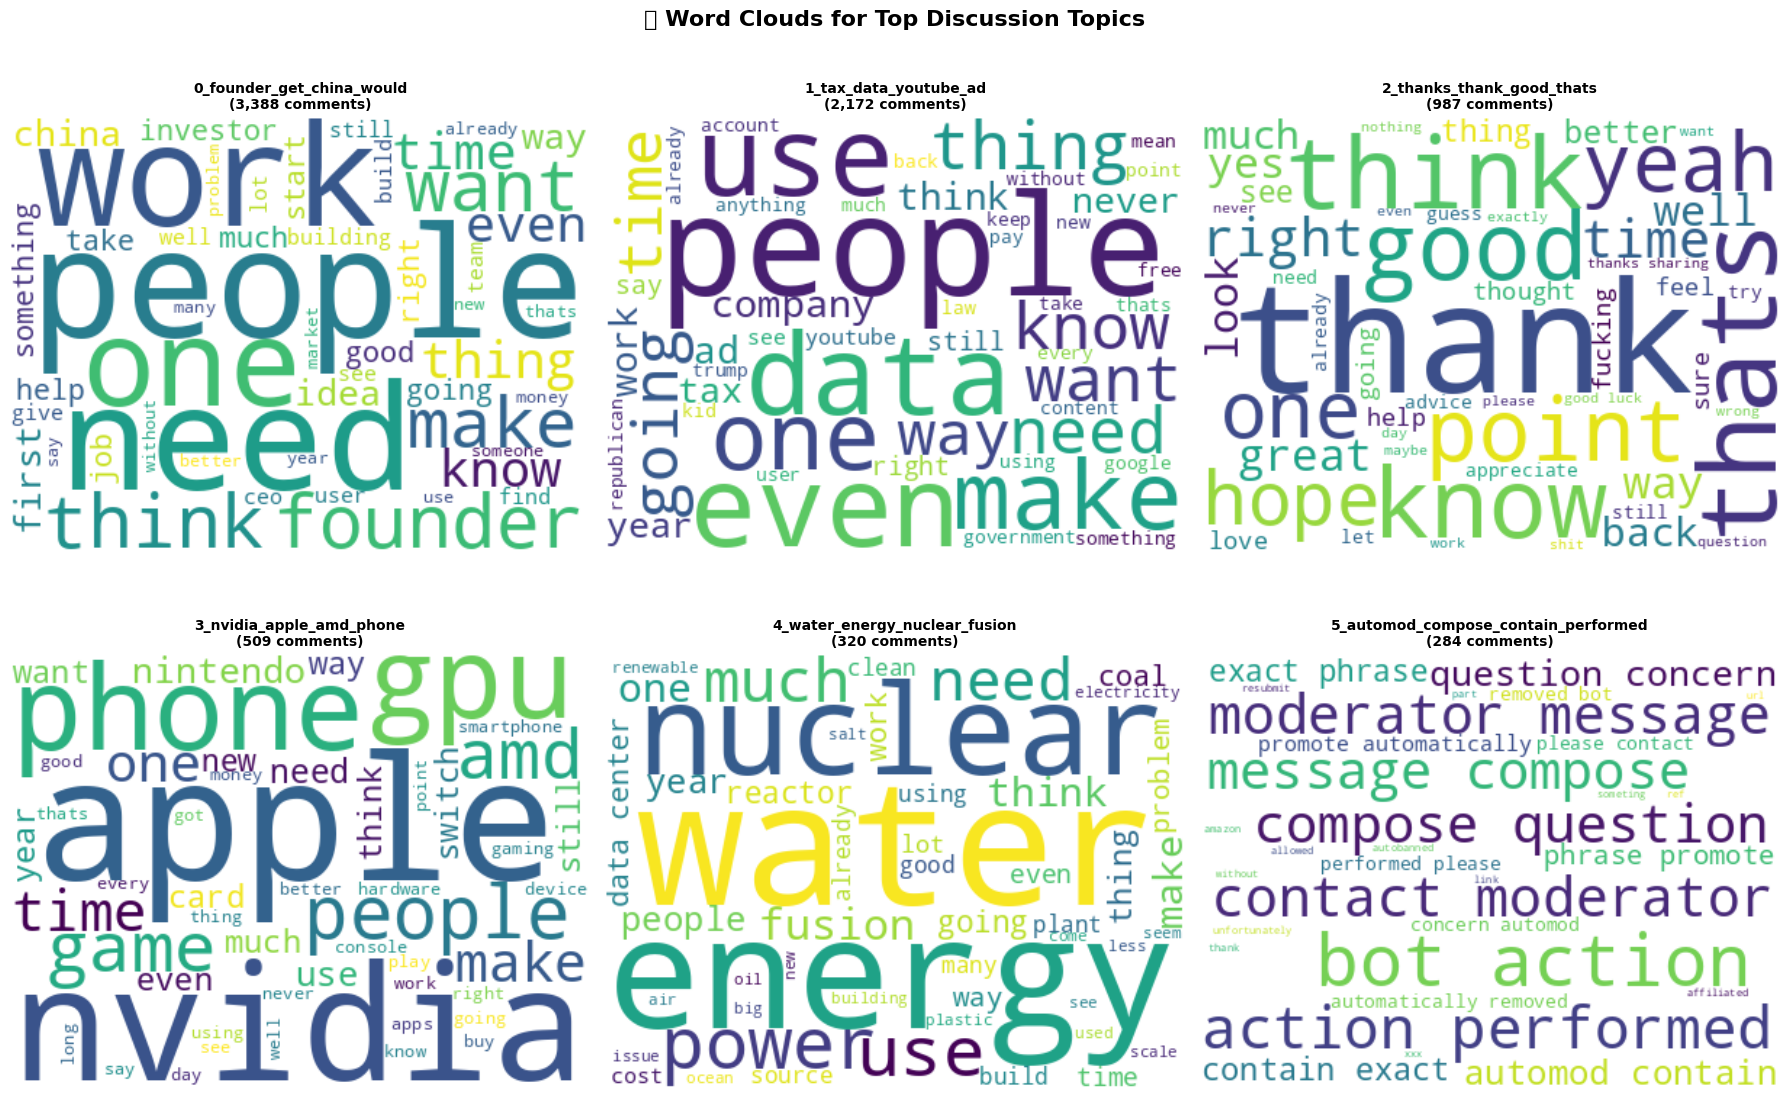

💾 Saved: topic_wordclouds.png


In [24]:
# New Cell: Topic-Based Word Clouds
print("🧠 Generating Topic-Based Word Clouds")
print("=" * 40)

if 'topic_name' in df.columns and 'processed_text' in df.columns:
    # Get top 6 topics for word clouds
    top_topics = df[df['topic_id'] != -1]['topic_name'].value_counts().head(6)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (topic, count) in enumerate(top_topics.items()):
        if idx < 6:  # Limit to 6 topics
            topic_text = ' '.join(df[df['topic_name'] == topic]['processed_text'])
            
            if topic_text.strip():
                wordcloud = WordCloud(
                    width=400, height=300,
                    background_color='white',
                    colormap='viridis',
                    max_words=50
                ).generate(topic_text)
                
                axes[idx].imshow(wordcloud, interpolation='bilinear')
                axes[idx].set_title(f'{topic}\n({count:,} comments)', fontsize=10, fontweight='bold')
                axes[idx].axis('off')
    
    # Remove empty subplots
    for idx in range(len(top_topics), 6):
        axes[idx].axis('off')
    
    plt.suptitle('🔤 Word Clouds for Top Discussion Topics', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Save topic word clouds
    fig.savefig("../outputs/topic_wordclouds.png", dpi=300, bbox_inches='tight')
    print("💾 Saved: topic_wordclouds.png")
else:
    print("❌ Missing data for topic-based word clouds")


In [25]:
# New Cell: Advanced Statistical Insights
print("📈 ADVANCED DATA INSIGHTS")
print("=" * 50)

# 1. Engagement Analysis
print("\n🔥 ENGAGEMENT ANALYSIS")
print("-" * 25)

if 'comment_score' in df.columns:
    engagement_stats = df.groupby('subreddit').agg({
        'comment_score': ['mean', 'median', 'std', 'max'],
        'comment_body': lambda x: x.str.len().mean()  # Average comment length
    }).round(2)
    
    print("📊 Comment Engagement by Subreddit:")
    for subreddit in df['subreddit'].unique():
        sub_data = df[df['subreddit'] == subreddit]
        
        avg_score = sub_data['comment_score'].mean()
        high_engagement = (sub_data['comment_score'] > sub_data['comment_score'].quantile(0.9)).sum()
        avg_length = sub_data['comment_body'].str.len().mean()
        
        print(f"\n🔹 r/{subreddit}:")
        print(f"   Average score: {avg_score:.2f}")
        print(f"   High-engagement comments (top 10%): {high_engagement:,}")
        print(f"   Average comment length: {avg_length:.0f} characters")

# 2. Language Complexity Analysis
print(f"\n📝 LANGUAGE COMPLEXITY ANALYSIS")
print("-" * 35)

def calculate_language_metrics(text_series):
    """Calculate various language complexity metrics"""
    word_counts = text_series.str.split().str.len()
    sentence_counts = text_series.str.count(r'[.!?]+') + 1
    
    return {
        'avg_words_per_comment': word_counts.mean(),
        'avg_sentences_per_comment': sentence_counts.mean(),
        'avg_words_per_sentence': (word_counts / sentence_counts).mean(),
        'vocabulary_richness': len(set(' '.join(text_series).split())) / len(' '.join(text_series).split())
    }

for subreddit in df['subreddit'].unique():
    sub_data = df[df['subreddit'] == subreddit]
    metrics = calculate_language_metrics(sub_data['comment_body'])
    
    print(f"\n🔹 r/{subreddit} Language Profile:")
    print(f"   Words per comment: {metrics['avg_words_per_comment']:.1f}")
    print(f"   Sentences per comment: {metrics['avg_sentences_per_comment']:.1f}")
    print(f"   Words per sentence: {metrics['avg_words_per_sentence']:.1f}")
    print(f"   Vocabulary richness: {metrics['vocabulary_richness']:.3f}")

# 3. Sentiment Distribution Insights
print(f"\n🎭 DETAILED SENTIMENT INSIGHTS")
print("-" * 35)

if 'sentiment' in df.columns:
    for subreddit in df['subreddit'].unique():
        sub_data = df[df['subreddit'] == subreddit]
        
        # Sentiment percentiles
        sentiment_percentiles = np.percentile(sub_data['sentiment'], [10, 25, 50, 75, 90])
        
        # Extreme sentiments
        very_positive = (sub_data['sentiment'] > 0.5).sum()
        very_negative = (sub_data['sentiment'] < -0.5).sum()
        
        print(f"\n🔹 r/{subreddit} Sentiment Distribution:")
        print(f"   10th percentile: {sentiment_percentiles[0]:.3f}")
        print(f"   25th percentile: {sentiment_percentiles[1]:.3f}")
        print(f"   Median: {sentiment_percentiles[2]:.3f}")
        print(f"   75th percentile: {sentiment_percentiles[3]:.3f}")
        print(f"   90th percentile: {sentiment_percentiles[4]:.3f}")
        print(f"   Very positive comments (>0.5): {very_positive:,} ({very_positive/len(sub_data)*100:.1f}%)")
        print(f"   Very negative comments (<-0.5): {very_negative:,} ({very_negative/len(sub_data)*100:.1f}%)")


📈 ADVANCED DATA INSIGHTS

🔥 ENGAGEMENT ANALYSIS
-------------------------
📊 Comment Engagement by Subreddit:

🔹 r/technology:
   Average score: 36.18
   High-engagement comments (top 10%): 1,745
   Average comment length: 188 characters

🔹 r/startups:
   Average score: 2.86
   High-engagement comments (top 10%): 541
   Average comment length: 339 characters

📝 LANGUAGE COMPLEXITY ANALYSIS
-----------------------------------

🔹 r/technology Language Profile:
   Words per comment: 32.7
   Sentences per comment: 3.3
   Words per sentence: 9.3
   Vocabulary richness: 0.095

🔹 r/startups Language Profile:
   Words per comment: 58.3
   Sentences per comment: 5.1
   Words per sentence: 10.8
   Vocabulary richness: 0.096

🎭 DETAILED SENTIMENT INSIGHTS
-----------------------------------

🔹 r/technology Sentiment Distribution:
   10th percentile: -0.664
   25th percentile: -0.340
   Median: 0.000
   75th percentile: 0.414
   90th percentile: 0.700
   Very positive comments (>0.5): 3,372 (19.2%)

In [26]:
# New Cell: Export Data Insights Summary
print("📋 GENERATING INSIGHTS SUMMARY REPORT")
print("=" * 45)

# Create a comprehensive insights dictionary
insights_summary = {
    'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'dataset_summary': {
        'total_comments': len(df),
        'date_range': f"{df['created_utc'].min().date()} to {df['created_utc'].max().date()}",
        'subreddits': df['subreddit'].value_counts().to_dict()
    }
}

# Add sentiment insights
if 'sentiment' in df.columns:
    insights_summary['sentiment_insights'] = {}
    for subreddit in df['subreddit'].unique():
        sub_data = df[df['subreddit'] == subreddit]
        insights_summary['sentiment_insights'][subreddit] = {
            'average_sentiment': sub_data['sentiment'].mean(),
            'sentiment_std': sub_data['sentiment'].std(),
            'positive_percentage': (sub_data['sentiment'] > 0.05).sum() / len(sub_data) * 100,
            'negative_percentage': (sub_data['sentiment'] < -0.05).sum() / len(sub_data) * 100
        }

# Add topic insights
if 'topic_name' in df.columns:
    insights_summary['topic_insights'] = {
        'total_topics': df['topic_id'].nunique() - 1,  # Exclude -1
        'top_topics': df[df['topic_id'] != -1]['topic_name'].value_counts().head(10).to_dict()
    }

# Save insights summary
import json
with open('../outputs/insights_summary.json', 'w') as f:
    json.dump(insights_summary, f, indent=2, default=str)

print("💾 Saved comprehensive insights to: insights_summary.json")

# Create a final summary table
summary_data = []
for subreddit in df['subreddit'].unique():
    sub_data = df[df['subreddit'] == subreddit]
    
    row = {
        'Subreddit': f"r/{subreddit}",
        'Comments': f"{len(sub_data):,}",
        'Avg Sentiment': f"{sub_data['sentiment'].mean():.3f}" if 'sentiment' in df.columns else 'N/A',
        'Positive %': f"{(sub_data['sentiment'] > 0.05).sum() / len(sub_data) * 100:.1f}%" if 'sentiment' in df.columns else 'N/A',
        'Avg Length': f"{sub_data['comment_body'].str.len().mean():.0f} chars",
        'Top Topic': df[df['subreddit'] == subreddit]['topic_name'].value_counts().index[0] if 'topic_name' in df.columns and len(df[df['subreddit'] == subreddit]) > 0 else 'N/A'
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print(f"\n📊 FINAL SUMMARY TABLE")
print("=" * 25)
print(summary_df.to_string(index=False))

print(f"\n🎉 COMPLETE ANALYSIS FINISHED!")
print("=" * 35)
print("Generated Files:")
print("• Word clouds for each subreddit")
print("• Sentiment-based word clouds") 
print("• Topic-based word clouds")
print("• Interactive sentiment vs engagement plot")
print("• Activity pattern visualizations")
print("• Comprehensive insights summary (JSON)")
print("\nAll files saved to ../outputs/ directory")


📋 GENERATING INSIGHTS SUMMARY REPORT
💾 Saved comprehensive insights to: insights_summary.json

📊 FINAL SUMMARY TABLE
   Subreddit Comments Avg Sentiment Positive % Avg Length               Top Topic
r/technology   17,575         0.027      40.6%  188 chars -1_people_would_get_one
  r/startups    5,699         0.377      70.7%  339 chars -1_people_would_get_one

🎉 COMPLETE ANALYSIS FINISHED!
Generated Files:
• Word clouds for each subreddit
• Sentiment-based word clouds
• Topic-based word clouds
• Interactive sentiment vs engagement plot
• Activity pattern visualizations
• Comprehensive insights summary (JSON)

All files saved to ../outputs/ directory
